### IMPORTING THE REQUIRED LIBRARIES

In [34]:
# importing libraries 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import linregress
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from census import Census
import pandas as pd
%matplotlib inline
import numpy as np
import requests
import time
import json
import re

### DATA CLEANING

### First dataset on Zillow Home Value Index, Median Sale Price, Monthly Home Sales, Foreclosure Resales
#### Source : Zillow

In [ ]:
# Suffixes:
# ZVHI = Zillow Home Value Index ($)
# MSR = Median Sales Price - Seasonally Adjusted ($)
# NS = Number of Sales
# FR = Foreclosure Resales (%)

#csv's are stored by ZIP code

home_values_csv = "Resources/Zip_Zhvi_AllHomes.csv"

home_sales_csv = "Resources/Sale_Prices_Zip.csv"

number_sales_csv = "Resources/Sale_Counts_Zip.csv"

foreclosure_resales_csv = "Resources/SalesPrevForeclosed_Share_Zip.csv"

home_values = pd.read_csv(home_values_csv, encoding="ISO-8859-1")
home_sales = pd.read_csv(home_sales_csv, encoding="ISO-8859-1")
number_sales = pd.read_csv(number_sales_csv, encoding="ISO-8859-1")
foreclosure_resales = pd.read_csv(foreclosure_resales_csv, encoding="ISO-8859-1")


In [ ]:
# US States to Two letter codes using python dictionary

# Dictionary obtained from rogerallen (https://gist.github.com/rogerallen/1583593)

us_state_abbreviations = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH',
    'Oklahoma': 'OK','Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
}

# Rename StateName columns

home_values = home_values.rename(columns={"RegionName":"ZIP Code",
                                          "2008-01":"2008-01_ZHVI",
                                          "2008-02":"2008-02_ZHVI"})
home_sales = home_sales.rename(columns={"RegionName":"ZIP Code",
                                        "StateName":"State"})
number_sales = number_sales.rename(columns={"RegionName":"ZIP Code",
                                            "StateName":"State",
                                            "seasAdj":"seasAdj_NS"})
foreclosure_resales = foreclosure_resales.rename(columns={"RegionName":"ZIP Code",
                                                          "StateName":"State"})

# Translate states into two letter codes for each file and handle errors
try:
    for index, row in home_sales.iterrows():
        state = home_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        home_sales.loc[index, "State"] = abbr

    for index, row in number_sales.iterrows():
        state = number_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        number_sales.loc[index, "State"] = abbr

    for index, row in foreclosure_resales.iterrows():
        state = foreclosure_resales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        foreclosure_resales.loc[index, "State"] = abbr
except:
    pass

In [ ]:
# Merge the home_values, home_sales, number_sales and foreclosure_resales

merge_homevalues_homesales = pd.merge(home_values, home_sales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_ZHVI", "_MSR"))
merge_number_sales_foreclosure_resales = pd.merge(number_sales, foreclosure_resales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_NS", "_FR"))
main_data = pd.merge(merge_homevalues_homesales, merge_number_sales_foreclosure_resales, on=["ZIP Code","State","RegionID"], how="outer")
print(main_data.head())

#### Examining Statistics Showing US Home Prices From 2008 to 2019

In [5]:
# Function to get mean of the columns from minimum month and year to maximum month and year with different suffixes

def findavg(data,year,suffix):
    x = []
    for i in data.columns:
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].mean(axis=1)
    return data[f"{year}_Avg_{suffix}"]

# Function to get sum of the columns from minimum month, year to maximum month, year with different suffixes

def findsum(data,year,suffix):
    x = []
    for i in data.columns:
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].sum(axis=1)
    return data[f"{year}_Avg_{suffix}"]

In [6]:
new_main_data = main_data[['RegionID', 'ZIP Code', 'City', 'State', 'CountyName']]
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName
0,84654,60657,Chicago,IL,Cook County
1,61637,10023,New York,NY,New York County
2,91982,77494,Katy,TX,Harris County
3,84616,60614,Chicago,IL,Cook County
4,91940,77449,Katy,TX,Harris County


In [7]:
# Join suffixes "ZHVI","MSR" and "FR" across different years by mean to new_main_data

years = [i for i in range(2008,2020,1)]
suffixes = ["ZHVI","MSR","FR"]

for year in years:
    for suffix in suffixes:
        new_main_data = new_main_data.join(findavg(main_data,year,suffix))
        
  
    new_main_data = new_main_data.join(findsum(main_data,year,"NS"))
        
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName,2008_Avg_ZHVI,2008_Avg_MSR,2008_Avg_FR,2008_Avg_NS,2009_Avg_ZHVI,...,2017_Avg_FR,2017_Avg_NS,2018_Avg_ZHVI,2018_Avg_MSR,2018_Avg_FR,2018_Avg_NS,2019_Avg_ZHVI,2019_Avg_MSR,2019_Avg_FR,2019_Avg_NS
0,84654,60657,Chicago,IL,Cook County,479900.645833,NaN,NaN,0.0,466041.694444,...,NaN,0.0,4.886200e+05,NaN,NaN,0.0,4.835098e+05,NaN,NaN,0.0
1,61637,10023,New York,NY,New York County,NaN,NaN,NaN,0.0,833515.733333,...,NaN,0.0,1.216848e+06,NaN,NaN,0.0,1.176796e+06,NaN,NaN,0.0
2,91982,77494,Katy,TX,Harris County,267059.388889,NaN,NaN,0.0,267583.416667,...,NaN,0.0,3.329190e+05,NaN,NaN,0.0,3.340930e+05,NaN,NaN,0.0
3,84616,60614,Chicago,IL,Cook County,606633.729167,NaN,NaN,0.0,594972.111111,...,NaN,0.0,6.361214e+05,NaN,NaN,0.0,6.297365e+05,NaN,NaN,0.0
4,91940,77449,Katy,TX,Harris County,125067.777778,NaN,NaN,0.0,119876.111111,...,NaN,0.0,1.760530e+05,NaN,NaN,0.0,1.830033e+05,NaN,NaN,0.0


##### First Dataframe with Suffixes:

**ZVHI = Zillow Home Value Index                                       
** MSR = Median Sales Price (Seasonally Adjusted)     
** NS = Number of Sales                                                        
** FR = Foreclosure Resales (%)

In [8]:
new_main_data.to_csv("Output/zillow_data.csv", index=False,encoding="utf-8", header=True)

In [9]:
state_data_1 = new_main_data[
                     ['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI',
                      '2012_Avg_ZHVI', '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI',
                      '2017_Avg_ZHVI', '2018_Avg_ZHVI', '2019_Avg_ZHVI', '2008_Avg_MSR','2009_Avg_MSR', 
                      '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR','2013_Avg_MSR', '2014_Avg_MSR', 
                      '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR', '2018_Avg_MSR', '2019_Avg_MSR', 
                      '2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS','2013_Avg_NS', 
                      '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS', '2018_Avg_NS', '2019_Avg_NS', 
                      '2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']
                    ]\
                        .groupby("State")
state_data_1.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2010_Avg_FR,2011_Avg_FR,2012_Avg_FR,2013_Avg_FR,2014_Avg_FR,2015_Avg_FR,2016_Avg_FR,2017_Avg_FR,2018_Avg_FR,2019_Avg_FR
0,IL,479900.645833,466041.694444,445775.916667,423604.722222,412033.055556,421352.583333,4.435987e+05,4.528587e+05,4.686318e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NY,NaN,833515.733333,836375.277778,858051.166667,888688.861111,949063.444444,1.068758e+06,1.138190e+06,1.197406e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,267059.388889,267583.416667,274168.222222,266745.861111,271493.027778,290686.722222,3.156699e+05,3.346299e+05,3.319498e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IL,606633.729167,594972.111111,565302.194444,534765.361111,523258.083333,537427.972222,5.705761e+05,5.916056e+05,6.132054e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TX,125067.777778,119876.111111,119721.722222,112142.083333,110622.833333,123323.277778,1.395240e+05,1.541215e+05,1.636677e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27091,Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.004900,0.006242,0.003967,0.000000,0.002383,0.005208,0.000000,0.003967,0.005880
27569,Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.034192,0.044183,0.037383,0.050175,0.050342,0.091842,0.049717,0.047750,0.091308,0.091160
27651,Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.025692,0.021233,0.002975,0.005283,0.006942,0.008550,0.001208,0.006942,0.012400,0.010875
27656,Vermont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.005950,0.005075,0.001700,0.011475,0.002317,0.000000,0.000000,0.017750,0.005682


In [10]:
# *ZVHI = Zillow Home Value Index
# * MSR = Median Sales Price (Seasonally Adjusted)
# * NS = Number of Sales
# * FR = Foreclosure Resales (%)

mean_zhvi = state_data_1[['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI', '2012_Avg_ZHVI',
                          '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI', '2017_Avg_ZHVI',
                          '2018_Avg_ZHVI', '2019_Avg_ZHVI']].mean()

mean_msr = state_data_1[['State','2008_Avg_MSR','2009_Avg_MSR', '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR',
                         '2013_Avg_MSR', '2014_Avg_MSR', '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR',
                         '2018_Avg_MSR', '2019_Avg_MSR']].mean()

sum_number_sales = state_data_1[['State','2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS',
                                 '2013_Avg_NS', '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS',
                                 '2018_Avg_NS', '2019_Avg_NS']].sum()

mean_fr = state_data_1[['State','2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']].mean()

merge_mean_zhvi_msr = pd.merge(mean_zhvi, mean_msr, on='State', how='outer')
merge_number_sales_fr = pd.merge(sum_number_sales, mean_fr, on='State', how='outer')
state_data = pd.merge(merge_mean_zhvi_msr, merge_number_sales_fr, on='State', how='outer')
print(state_data.head())

         2008_Avg_ZHVI  2009_Avg_ZHVI  2010_Avg_ZHVI  2011_Avg_ZHVI  \
State                                                                 
AK       257757.731674  255277.256173  255265.845679  252652.662037   
AL       142287.102771  137912.212703  132560.954521  127438.048756   
AR       109428.506791  105079.607528  102444.345622  100620.504960   
AZ       257791.880246  222270.168886  208525.831265  192496.057547   
Alabama            NaN            NaN            NaN            NaN   

         2012_Avg_ZHVI  2013_Avg_ZHVI  2014_Avg_ZHVI  2015_Avg_ZHVI  \
State                                                                 
AK       257154.490616  261483.093559  260587.859272  263911.006225   
AL       124757.877755  124216.831304  123857.456570  126152.310004   
AR       100541.646575  101893.995841  102221.952317  102801.309430   
AZ       192090.256004  210370.328371  219667.363194  224545.767161   
Alabama            NaN            NaN            NaN            NaN   

    

#### Data Exploration to Show Average U.S Housing Price,  Seasonally Adjusted Median Sales Price and Average Number of Home Sales From 2008 To 2019

[226717.32558555354, 212334.19845306562, 206728.87416745396, 198725.5338227128, 196922.08857037974, 203760.19914628984, 210862.89424676346, 216561.1215804045, 223793.4777808017, 232759.2742760402, 244449.13714964397, 252654.45357852362]


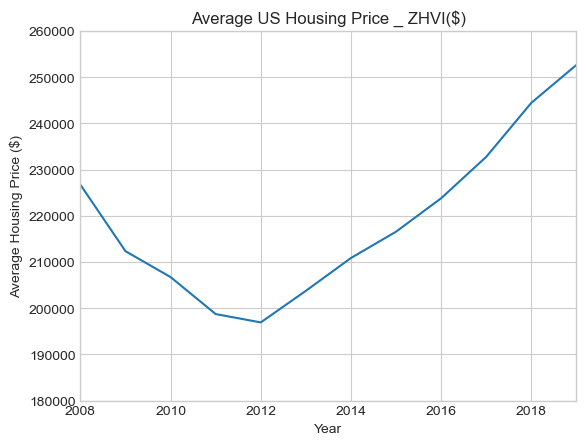

In [11]:
# Average U.S Housing Price

average_home_values = [state_data["2008_Avg_ZHVI"].mean(), state_data["2009_Avg_ZHVI"].mean(),state_data["2010_Avg_ZHVI"].mean(),
                  state_data["2011_Avg_ZHVI"].mean(),state_data["2012_Avg_ZHVI"].mean(), state_data["2013_Avg_ZHVI"].mean(),
                  state_data["2014_Avg_ZHVI"].mean(), state_data["2015_Avg_ZHVI"].mean(), state_data["2016_Avg_ZHVI"].mean(),
                  state_data["2017_Avg_ZHVI"].mean(), state_data["2018_Avg_ZHVI"].mean(), state_data["2019_Avg_ZHVI"].mean()]
print(average_home_values)
average_home_values
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
plt.title("Average US Housing Price _ ZHVI($)")
plt.xlabel("Year")
plt.ylabel("Average Housing Price ($)")
plt.ylim(180000,260000)
plt.xlim(2008,2019)
plt.plot(years,average_home_values)
plt.savefig("Output/average_house_price.png")

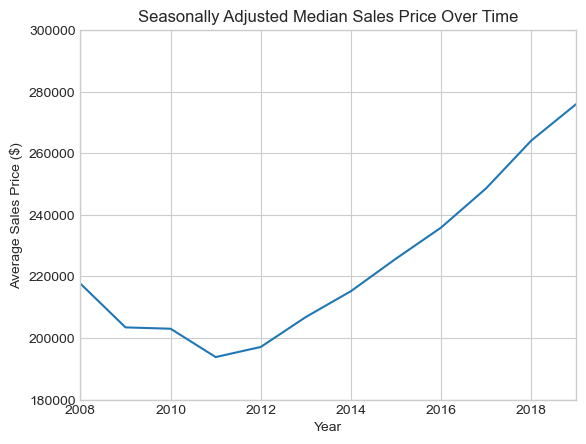

In [12]:
# Plot Of U.S Seasonally Adjusted Median Sales Price From 2008 To 2019

ave_sales_price = [state_data["2008_Avg_MSR"].mean(), state_data["2009_Avg_MSR"].mean(),state_data["2010_Avg_MSR"].mean(),
                  state_data["2011_Avg_MSR"].mean(),state_data["2012_Avg_MSR"].mean(), state_data["2013_Avg_MSR"].mean(),
                  state_data["2014_Avg_MSR"].mean(), state_data["2015_Avg_MSR"].mean(), state_data["2016_Avg_MSR"].mean(),
                  state_data["2017_Avg_MSR"].mean(), state_data["2018_Avg_MSR"].mean(), state_data["2019_Avg_MSR"].mean()]
plt.title("Seasonally Adjusted Median Sales Price Over Time")
plt.xlabel("Year")
plt.ylabel("Average Sales Price ($)")
plt.ylim(180000,300000)
plt.xlim(2008,2019)
plt.plot(years,ave_sales_price)
plt.savefig("Output/avg_sales_price.png")

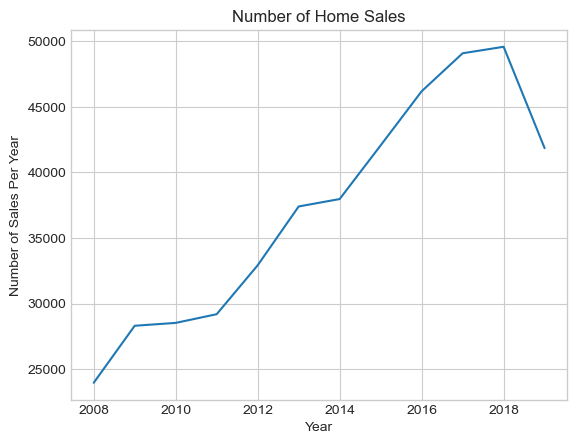

In [13]:
# Plot of Avg Number of Sales Per Month

ave_home_sales = [state_data["2008_Avg_NS"].mean(), state_data["2009_Avg_NS"].mean(),state_data["2010_Avg_NS"].mean(),
                  state_data["2011_Avg_NS"].mean(),state_data["2012_Avg_NS"].mean(), state_data["2013_Avg_NS"].mean(),
                  state_data["2014_Avg_NS"].mean(), state_data["2015_Avg_NS"].mean(), state_data["2016_Avg_NS"].mean(),
                  state_data["2017_Avg_NS"].mean(), state_data["2018_Avg_NS"].mean(), state_data["2019_Avg_NS"].mean()]
plt.title("Number of Home Sales")
plt.xlabel("Year")
plt.ylabel("Number of Sales Per Year")
plt.plot(years, ave_home_sales)
plt.savefig("Output/avg_num_sales.png")

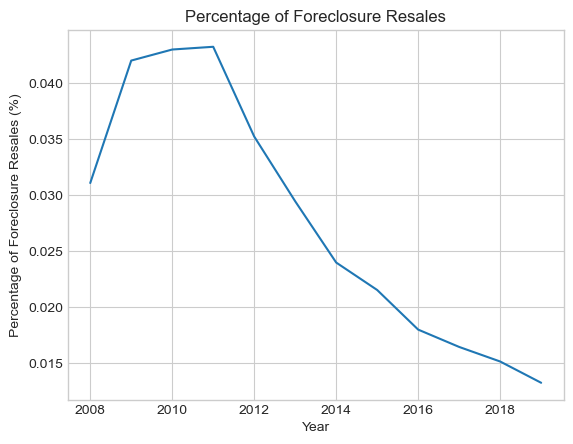

In [14]:
# Plot of Avg Foreclosure Resales

ave_foreclosure_resales = [state_data["2008_Avg_FR"].mean(), state_data["2009_Avg_FR"].mean(),state_data["2010_Avg_FR"].mean(),
                  state_data["2011_Avg_FR"].mean(),state_data["2012_Avg_FR"].mean(), state_data["2013_Avg_FR"].mean(),
                  state_data["2014_Avg_FR"].mean(), state_data["2015_Avg_FR"].mean(), state_data["2016_Avg_FR"].mean(),
                  state_data["2017_Avg_FR"].mean(), state_data["2018_Avg_FR"].mean(), state_data["2019_Avg_FR"].mean()]
plt.title("Percentage of Foreclosure Resales")
plt.xlabel("Year")
plt.ylabel("Percentage of Foreclosure Resales (%)")
plt.plot(years, ave_foreclosure_resales)
plt.savefig("Output/pct_foreclosure_sales.png")

In [15]:
state_data = state_data.reset_index()

housing_price_average = pd.DataFrame([state_data["State"],state_data["2008_Avg_ZHVI"],state_data["2009_Avg_ZHVI"], state_data["2010_Avg_ZHVI"],
                        state_data["2011_Avg_ZHVI"], state_data["2012_Avg_ZHVI"], state_data["2013_Avg_ZHVI"],
                         state_data["2014_Avg_ZHVI"], state_data["2015_Avg_ZHVI"], state_data["2016_Avg_ZHVI"],
                         state_data["2017_Avg_ZHVI"], state_data["2018_Avg_ZHVI"], state_data["2019_Avg_ZHVI"]
                        ]
                                    )
housing_price_average = housing_price_average.T

In [16]:
#states with highest increase and lowest decrease in housing prices 

housing_price_average["Change"] = housing_price_average["2019_Avg_ZHVI"] - housing_price_average["2008_Avg_ZHVI"]

prices_descending = housing_price_average.sort_values(by=["Change"], ascending=False)
prices_descending.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,2018_Avg_ZHVI,2019_Avg_ZHVI,Change
14,DC,483599.190278,458940.069444,459613.419444,459278.670833,467900.161111,506845.480159,544902.232804,563037.734127,584612.025132,609986.671958,634939.816138,662305.81241,178706.622132
8,CA,468233.71145,423004.034608,422985.651603,401367.360069,406446.894985,446805.162324,476875.116913,503387.102992,536483.483562,569431.051039,615508.107134,626331.293727,158097.582277
9,CO,253618.9812,245395.782154,241199.468952,237452.875291,239758.262169,255112.318367,270234.277054,292758.443008,313756.488091,331518.951534,355129.494521,370922.916812,117303.935612
94,WA,301549.566024,274495.116059,262043.948068,241961.654072,235502.205822,252028.226019,267069.008776,286110.885013,310317.604785,339948.756182,372878.542795,384768.82451,83219.258486
38,MA,386248.001093,364574.604782,365931.213568,354749.991576,349036.319501,366042.818122,385413.361665,403679.996237,414750.0359,430517.705478,451397.302256,459662.33497,73414.333876


In [17]:
prices_ascending = housing_price_average.sort_values(by=["Change"])
prices_ascending.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,2018_Avg_ZHVI,2019_Avg_ZHVI,Change
10,CT,347249.215342,323905.392458,313118.014583,300227.801698,288950.195595,293717.917015,294941.322222,295011.945601,298319.426761,301334.038597,306134.3324,307665.410746,-39583.804596
58,NJ,420846.992024,391781.085328,380716.97748,361595.327081,349549.487906,354848.034549,366802.374086,368908.896789,370147.752516,376508.540351,389347.728254,394467.30938,-26379.682645
39,MD,353503.660979,319818.078107,303927.047789,293501.672693,286751.73184,295964.020434,304431.464222,305692.799603,308861.770329,318140.8241,328420.79386,333409.108621,-20094.552358
59,NM,216786.433745,203819.225,199047.547267,185492.529446,181806.536267,181872.024396,181819.087538,177093.50677,179636.442558,184753.325784,189075.21819,197807.643695,-18978.79005
96,WV,105932.952767,102891.732462,103329.654671,98392.58644,96010.115346,95029.841646,93818.412367,88433.676253,88496.260273,88742.710274,91196.160431,93635.16007,-12297.792697


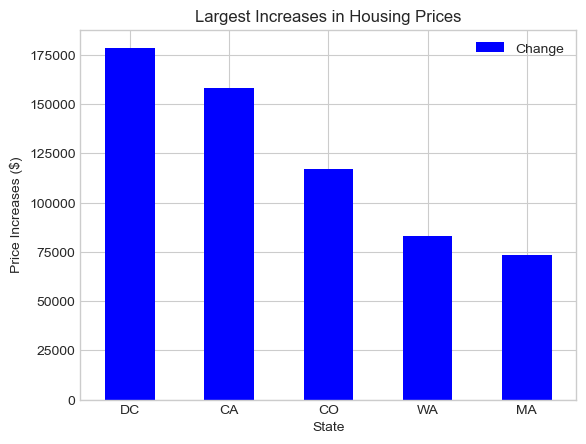

In [18]:
increase_df = pd.DataFrame({"State":["DC","CA","CO","WA","MA"],"Change":[178707,158098,117304,83219.2,73414.3]})
ax = increase_df.plot.bar(x="State", y="Change", color="Blue", rot=0)
ax.grid(True)
ax.set_axisbelow(True)
ax.yaxis.set_minor_locator(MultipleLocator(12500))
ax.set_ylabel("Price Increases ($)")
ax.title.set_text("Largest Increases in Housing Prices")
plt.savefig("Output/largest increases in house prices.png")

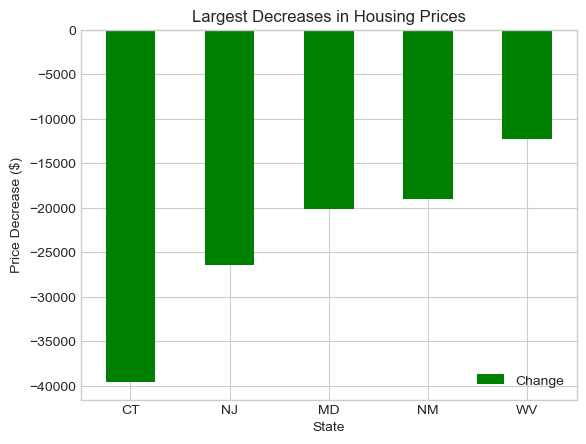

In [19]:
decrease_df = pd.DataFrame({"State":["CT","NJ","MD","NM","WV"],"Change":[-39583.8,-26379.7,-20094.5,-18978.8, -12297.8]})
ax = decrease_df.plot.bar(x="State", y="Change", rot=0, color="green")
ax.set_ylabel("Price Decrease ($)")
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.grid(True)
ax.set_axisbelow(True)
ax.title.set_text("Largest Decreases in Housing Prices")
plt.savefig("Output/largest_decreases.png")

### Unemployment Rate Across All States in the U.S


In [20]:
# Get unemployment_csv and convert to dataframe
unemployment_csv = "Resources/Cleaned_BLS_Unemployment-Rate-by-State_2008-2019_1-11-2020.csv"
unemployment_data = pd.read_csv(unemployment_csv, encoding="ISO-8859-1")

unemployment_data = unemployment_data.rename(columns={"State Abbreviation":"State"}).set_index("State")


In [21]:
# Grab the numeric column headers, convert to string and concatenate "_unemployment"

unemployment_data = unemployment_data[[str(i) for i in range(2008,2020,1)]]
for i in range(2008,2020,1):
    unemployment_data = unemployment_data.rename(columns={str(i):f"{i}_unemployment"})
unemployment_data.head()

,2008_unemployment,2009_unemployment,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,
AL,5.72,10.99,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AK,6.71,7.73,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AZ,6.14,9.93,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
AR,5.50,7.83,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
CA,7.29,11.14,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [22]:
biggest_data = state_data.join(unemployment_data, on="State").round(2)
biggest_data.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
4,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Exploration in U.S From 2008 To 2019 to Show Unemployment 

In [23]:
ave_unemployment = [biggest_data["2008_unemployment"].mean(), biggest_data["2009_unemployment"].mean(),biggest_data["2010_unemployment"].mean(),
                   biggest_data["2011_unemployment"].mean(), biggest_data["2012_unemployment"].mean(),biggest_data["2013_unemployment"].mean(),
                   biggest_data["2014_unemployment"].mean(), biggest_data["2015_unemployment"].mean(), biggest_data["2016_unemployment"].mean(),
                   biggest_data["2017_unemployment"].mean(), biggest_data["2018_unemployment"].mean(),biggest_data["2019_unemployment"].mean() ]

#largest decreases
ct_house_price = [347249.22, 323905.39, 313118.01, 300227.8, 288950.2, 293717.92, 294941.32, 295011.95, 298319.43, 301334.04, 306134.33, 307665]
nj_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
md_house_price = [353504, 319818, 303927, 293502, 286752, 295964, 304431, 305693, 308862, 318141, 328421, 333409]
nm_house_price = [216786, 203819, 199048, 185493, 181807, 181872, 181819, 177094, 179636, 184753, 189075, 197808]
wv_house_price = [105933, 102892, 103330, 98392.6, 96010.1, 95029.8, 93818.4, 88433.7, 88496.3, 88742.7, 91196.2, 93635.2]

#largest increases
dc_house_price = [483599, 458940, 459613, 459279, 467900, 506845, 544902, 563038, 584612, 609987, 634940, 662306]
ca_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
co_house_price = [253619, 245396, 241199, 237453, 239758, 255112, 270234, 292758, 313756, 331519, 355129, 370923]
wa_house_price = [301550, 274495, 262044, 241962, 235502, 252028, 267069, 286111, 310318, 339949, 372879, 384769]
ma_house_price = [386248, 364575, 365931, 354750, 349036, 366043, 385413, 403680, 414750, 430518, 451397, 459662]

y1 = ct_house_price
y2 = nj_house_price
y3 = md_house_price
y4 = nm_house_price
y5 = wv_house_price

### Dataset on Loans Across All States in the U.S

In [24]:
# Get the sheets named "studentloan" and "total" from the excel worksheet
areaReport_csv = "Resources/area_report_by_year.xlsx"
sheetname = ["studentloan", "total"]
df = [" ", " "]

for i in range(len(sheetname)):
    df[i] = pd.read_excel(areaReport_csv, sheet_name=sheetname[i])
    df[i] = df[i].iloc[2:len(df[i])-1,:]
    
    xls_header = df[i].iloc[0]
    df[i] = df[i][1:]
   
    df[i].columns = xls_header
    df[i] = df[i].set_index("state")
    df[i].rename_axis(None).index.name

studentLoan_data = df[0]
totalLoan_data = df[1]

studentLoan_data = studentLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
totalLoan_data = totalLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
for i in range(2008,2019,1):
    studentLoan_data = studentLoan_data.rename(columns={f"Q4_{i}":f"{i}_studentLoan"})
    totalLoan_data = totalLoan_data.rename(columns={f"Q4_{i}":f"{i}_totalLoan"})
studentLoan_data.head()
totalLoan_data.head()

2,2008_totalLoan,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
state,,,,,,,,,,,
AK,54110,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,35540,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,28940,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,65870,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,86940,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


In [25]:
latest_merge = biggest_data.join(studentLoan_data, on="State")\
               .join(totalLoan_data, on="State").round(2)

latest_merge.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
4,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dataset on Median Household Income By States in the U.S

In [26]:
# Get income_csv, convert to dataframe and concatenate "_income" to column headers
income_csv = "Resources/us_income.xlsx"

income_data = pd.read_excel(income_csv).set_index("State")
for i in range(2008,2020,1):
    income_data = income_data.rename(columns={i:f"{i}_income"})
income_data.head()

,2008_income,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
State,,,,,,,,,,,
AK,44476.0,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,63989.0,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,46914.0,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,39586.0,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,57014.0,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [27]:
latest_merge = latest_merge.join(income_data, on="State")\
               .round(2)

latest_merge.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
0,AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,...,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179.0
1,AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,...,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936.0
2,AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,...,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734.0
3,AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,...,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283.0
4,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
latest_merge.fillna(latest_merge.mean(), inplace=True)
latest_merge = latest_merge.round(2)
total_data = latest_merge
massive_data = latest_merge
massive_data = massive_data.drop(['2019_Avg_ZHVI','2019_Avg_MSR', '2019_Avg_NS', '2019_Avg_FR', '2019_unemployment'],axis=1).set_index("State")
massive_data.head()

C:\Users\vyshn\AppData\Local\Temp\ipykernel_28232\3129002401.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  latest_merge.fillna(latest_merge.mean(), inplace=True)


,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009_income,2010_income,2011_income,2012_income,2013_income,2014_income,2015_income,2016_income,2017_income,2018_income
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,39980.00,40933.00,42590.00,43464.00,41381.00,42278.00,44509.00,47221.0,51113.00,63179.00
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,61604.00,57848.00,57431.00,63648.00,61137.00,67629.00,75112.00,75723.0,72231.00,49936.00
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,45739.00,46896.00,48621.00,47044.00,50602.00,49254.00,52248.00,57100.0,61125.00,68734.00
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,36538.00,38587.00,41302.00,39018.00,39919.00,44922.00,42798.00,45907.0,48829.00,62283.00
Alabama,226717.33,212334.20,206728.87,198725.53,196922.09,203760.20,210862.89,216561.12,223793.48,232759.27,...,49857.31,50018.27,50686.47,52007.22,52810.78,55223.61,57011.33,59179.0,61640.06,64423.39


### DATA ANALYSIS

In [35]:
def showStatedata(data):
    # Transpose data to make states the columns
    x = massive_data.T
    state = str(data).upper()
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    state_keys = list(us_state_abbreviations.keys())
    state_values = list(us_state_abbreviations.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    # Create a list of dataframes for each suffix
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]
    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    state_df.fillna(state_df.mean(), inplace=True)
    
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
   
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    print(f"{name_state}'s Strongest Pearson Correlation Factors")
    print("---------------------------------------------------")
    print(cor)
    
    # First plot : Median sale price vs year
    plt.figure(figsize=(18,12))
    plt.subplot(2, 2, 1)
    corr_df = state_df[corr]
    y_values = state_df["Median Sales Price ($)"]
    plt.plot(corr_df.index, y_values, color = "r")
    plt.title(f'{name_state} {y_values.name} Vs {corr_df.index.name}',fontsize=17)
    plt.xlabel(f'{corr_df.index.name}', fontsize=16)
    plt.ylabel(f'{y_values.name}', fontsize=16)
    plt.grid(True)
    
    # Second Plot :  Median sale price vs student loan
    plt.subplot(2, 2, 2)
    x_values = corr_df.iloc[:,0]
    plt.scatter(x_values, y_values, color='grey')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"b-")
   
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{y_values.name}', fontsize=16)
    plt.grid(True)
    
    # Third Plot :  Median sale price vs unemployment rate
    plt.subplot(2, 2, 3)
    x_values = corr_df.iloc[:,1]
    plt.scatter(x_values, y_values, color='brown')
    plt.title(f'{name_state} {state_df.columns.values[0]} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"g-")
   
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=16)
    plt.grid(True)
    
    # Fourth Plot: Median sale price vs Foreclosure sales
    plt.subplot(2, 2, 4)
    x_values = corr_df.iloc[:,2]
    plt.scatter(x_values, y_values, color='green')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"y-")
    
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=16)
    plt.grid(True)
    plt.show
    plt.savefig(f"Output/{name_state} plots")
    return

District of Columbia's Strongest Pearson Correlation Factors
---------------------------------------------------
Foreclosure Resales (%)    0.957327
Zillow Home Value ($)      0.948018
Student Loan ($)           0.898820
Divorce Rate (%)           0.867530
Name: Median Sales Price ($), dtype: float64
California's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)      0.996609
Divorce Rate (%)           0.935783
Foreclosure Resales (%)    0.929705
Unemployment Rate (%)      0.751412
Name: Median Sales Price ($), dtype: float64
Colorado's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)      0.982707
Total Loan ($)             0.922247
Foreclosure Resales (%)    0.906351
Divorce Rate (%)           0.886504
Name: Median Sales Price ($), dtype: float64
Washington's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home V

[None, None, None, None, None]

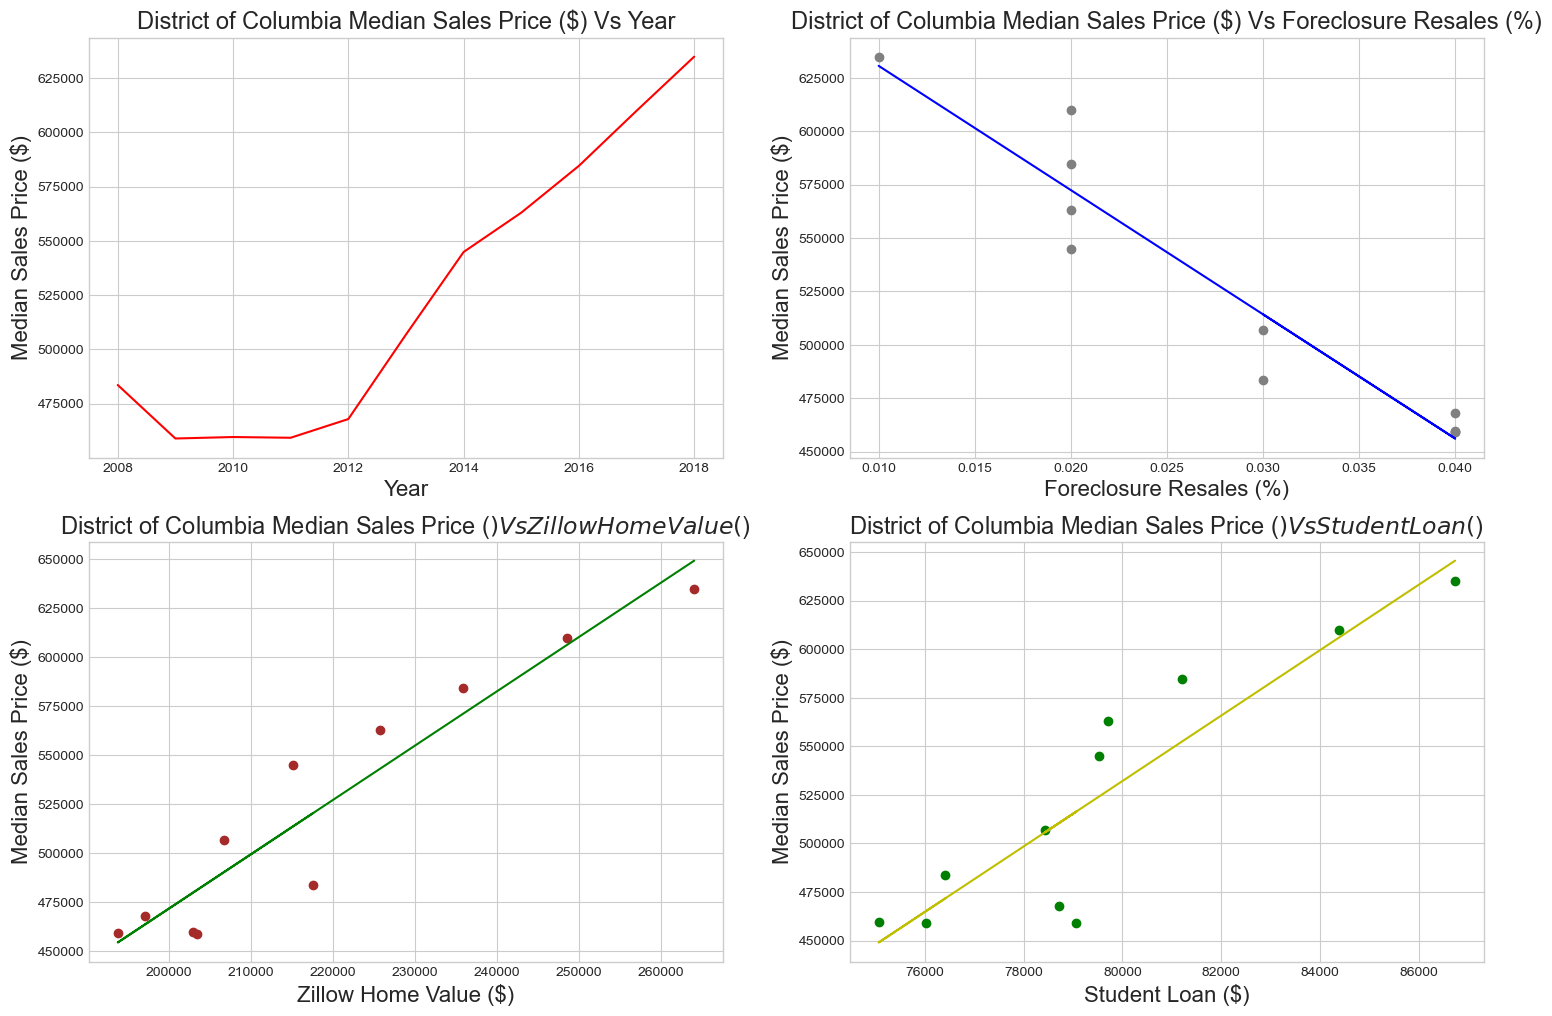

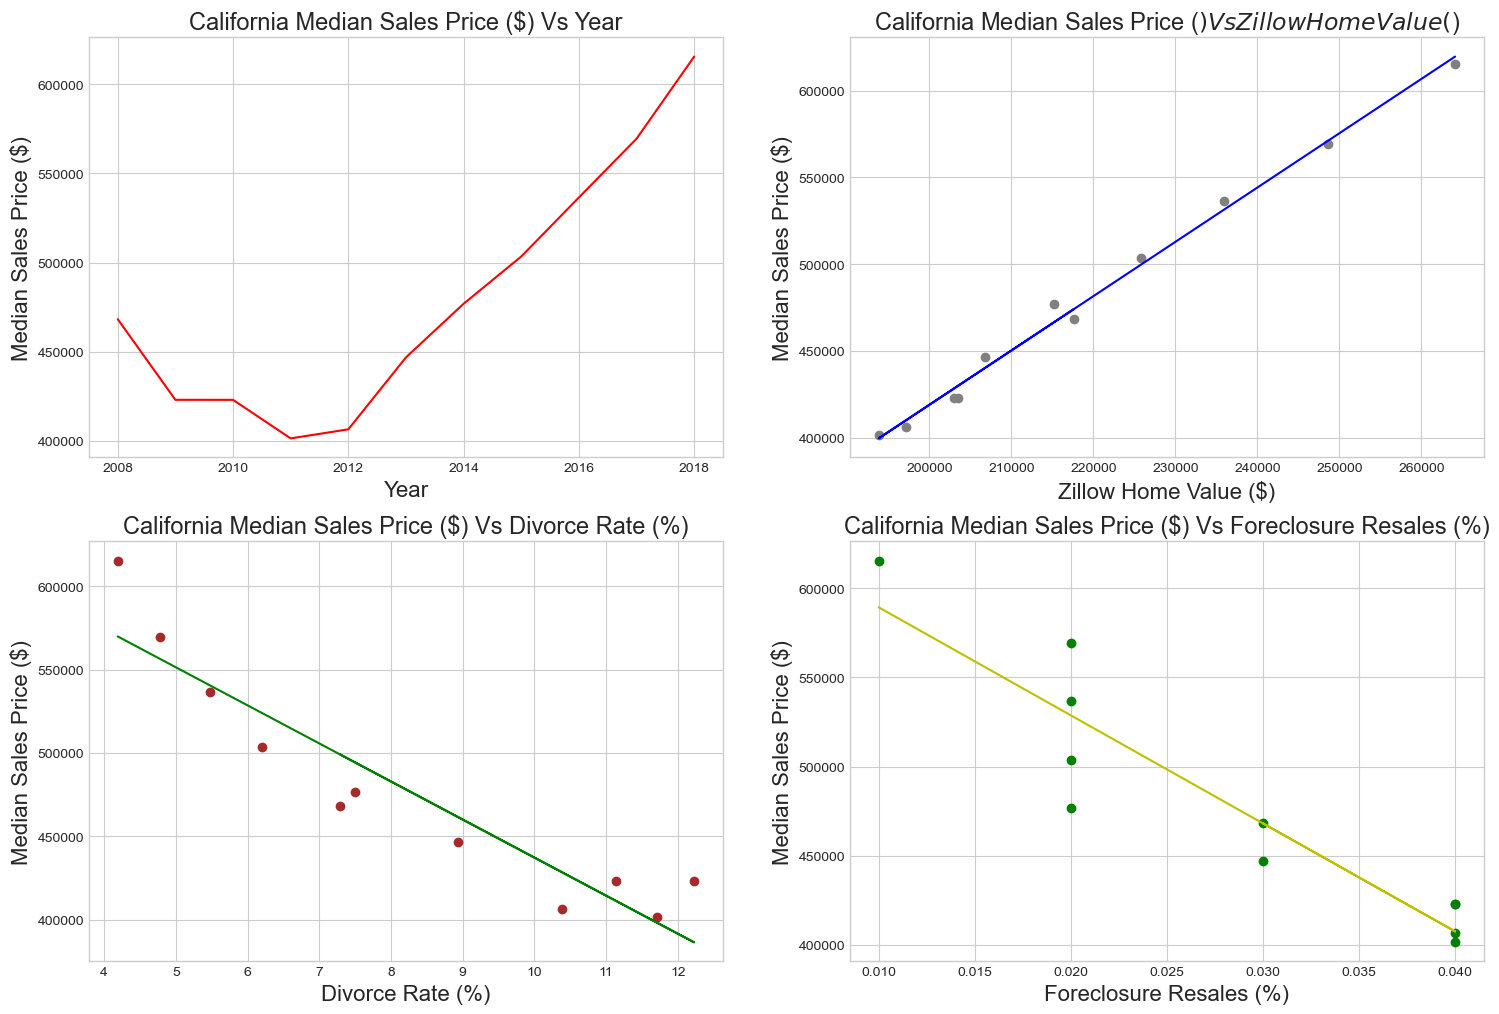

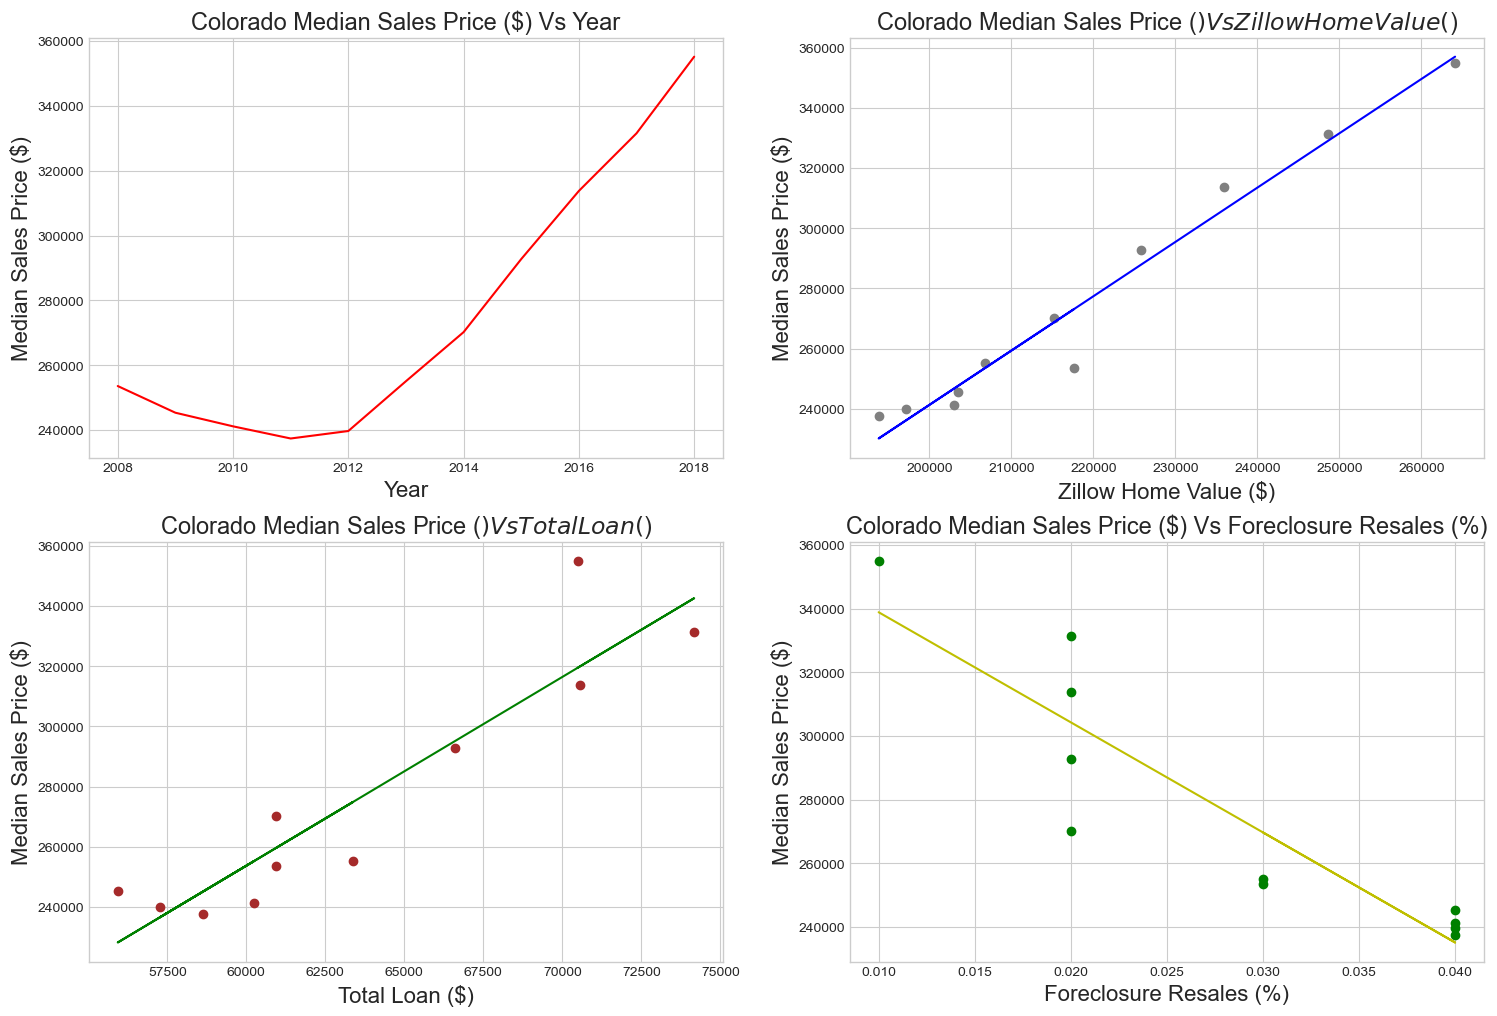

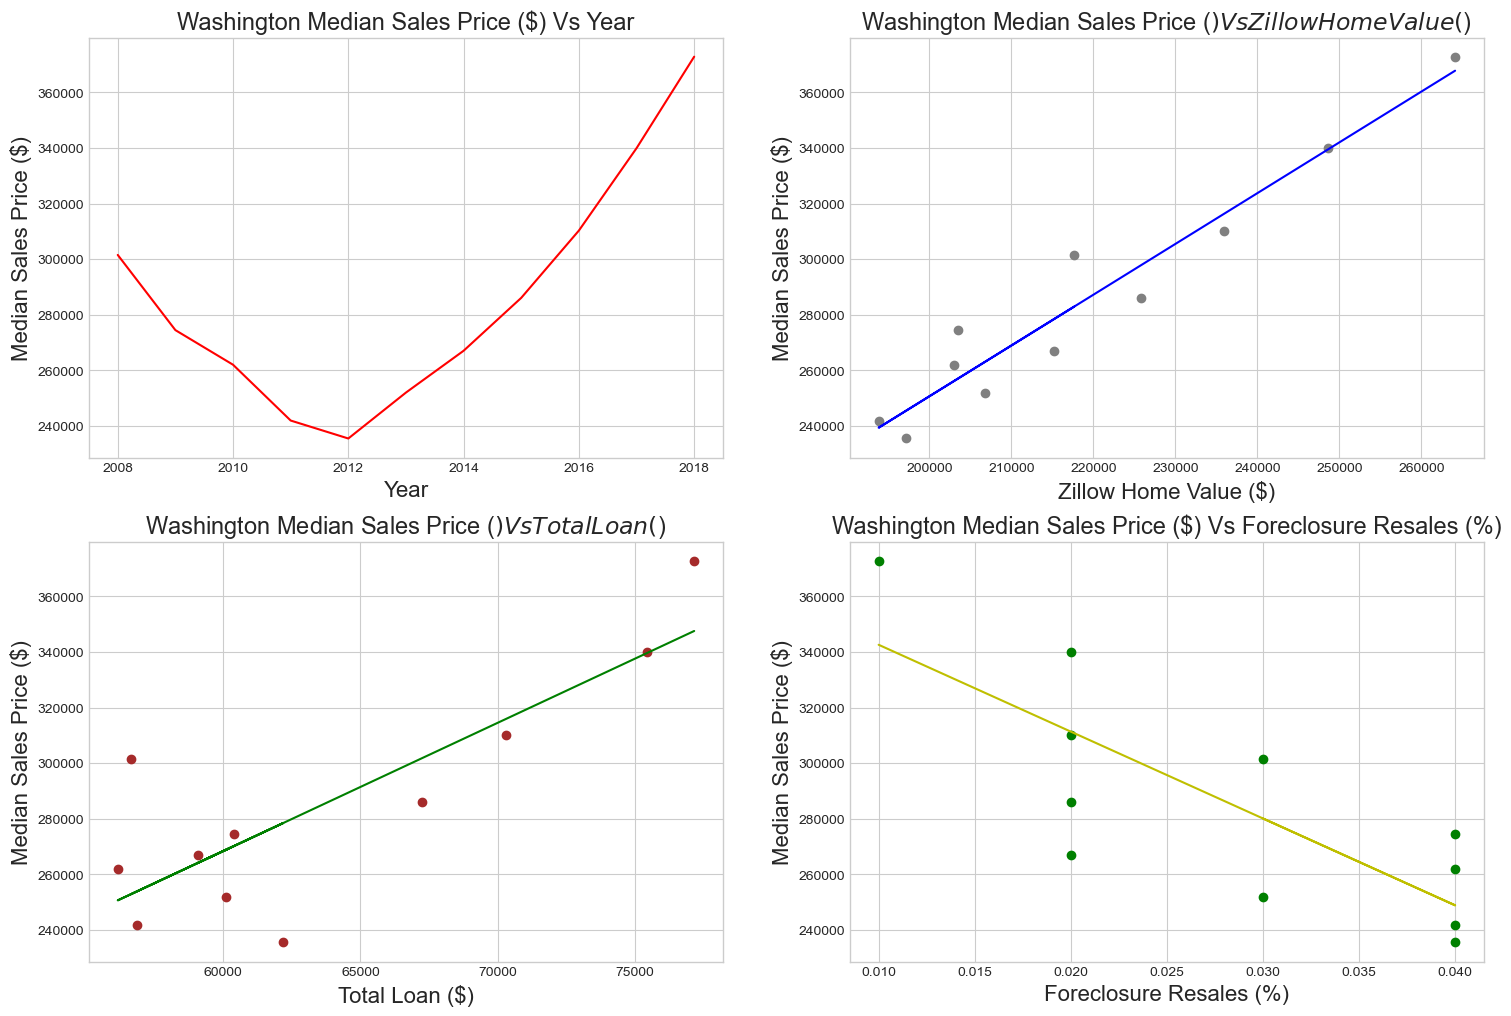

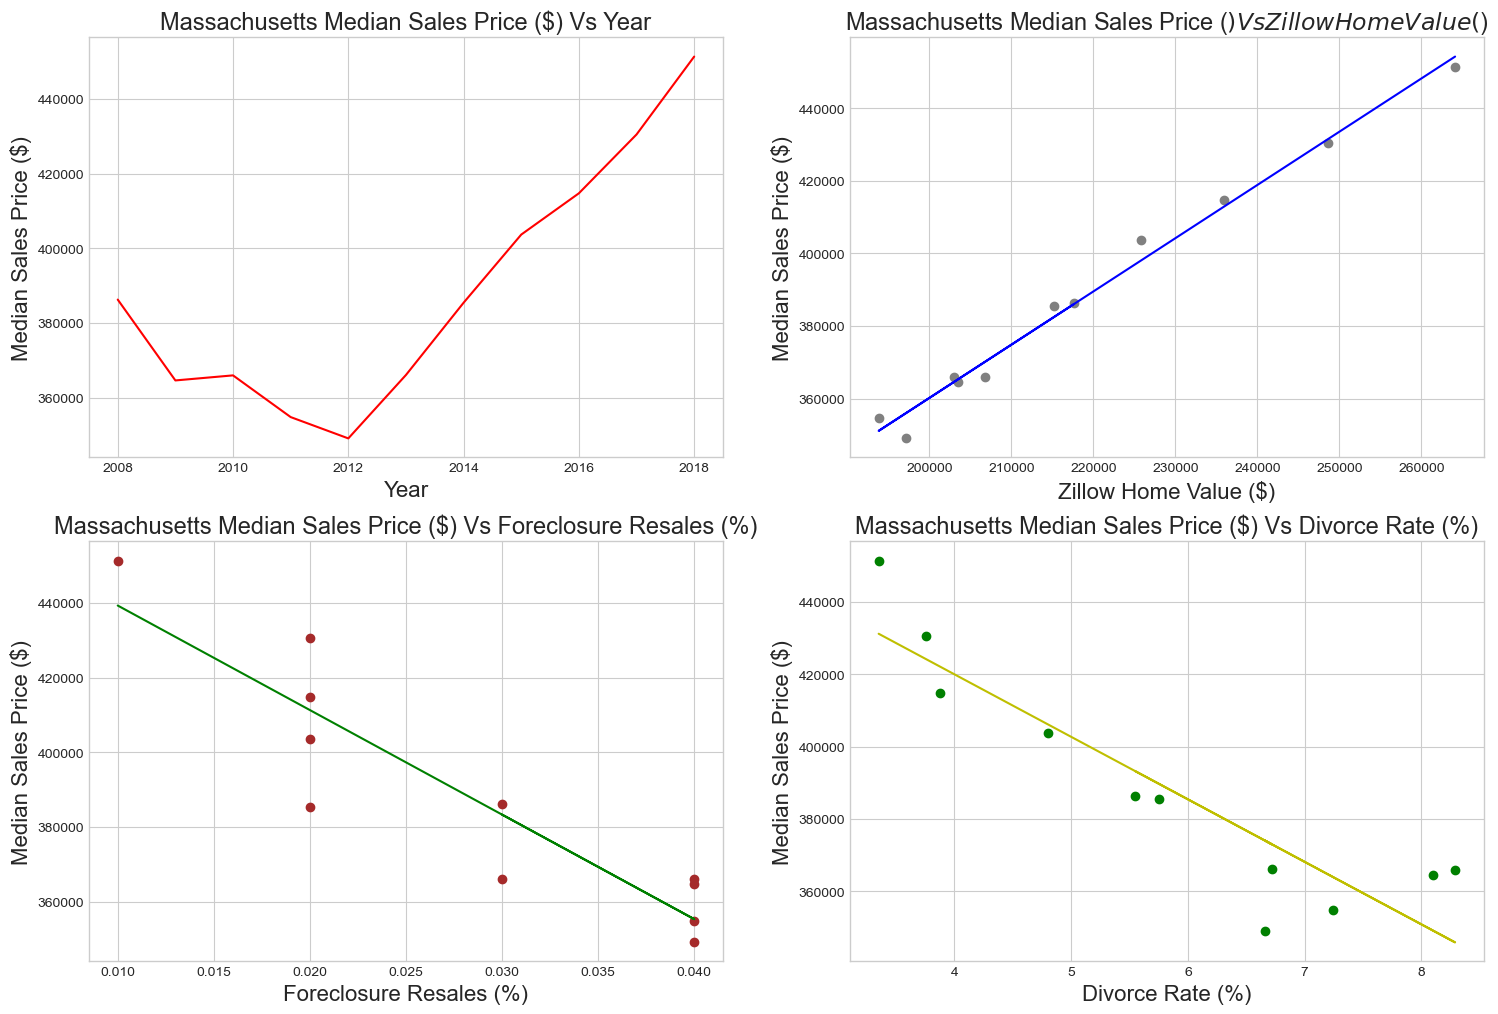

In [30]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest increase in MSR
greatest_increase = ["DC","CA","CO","WA","MA"]
[showStatedata(x) for x in greatest_increase]

Connecticut's Strongest Pearson Correlation Factors
---------------------------------------------------
Student Loan ($)           0.733368
Unemployment Rate (%)      0.634021
Total Loan ($)             0.397807
Foreclosure Resales (%)    0.195684
Name: Median Sales Price ($), dtype: float64
New Jersey's Strongest Pearson Correlation Factors
---------------------------------------------------
Student Loan ($)         0.501883
Divorce Rate (%)         0.395383
Unemployment Rate (%)    0.379391
Zillow Home Value ($)    0.296282
Name: Median Sales Price ($), dtype: float64
Maryland's Strongest Pearson Correlation Factors
---------------------------------------------------
Student Loan ($)           0.776818
Divorce Rate (%)           0.652607
Zillow Home Value ($)      0.484014
Foreclosure Resales (%)    0.339338
Name: Median Sales Price ($), dtype: float64
New Mexico's Strongest Pearson Correlation Factors
---------------------------------------------------
Student Loan ($)           0.8

[None, None, None, None, None]

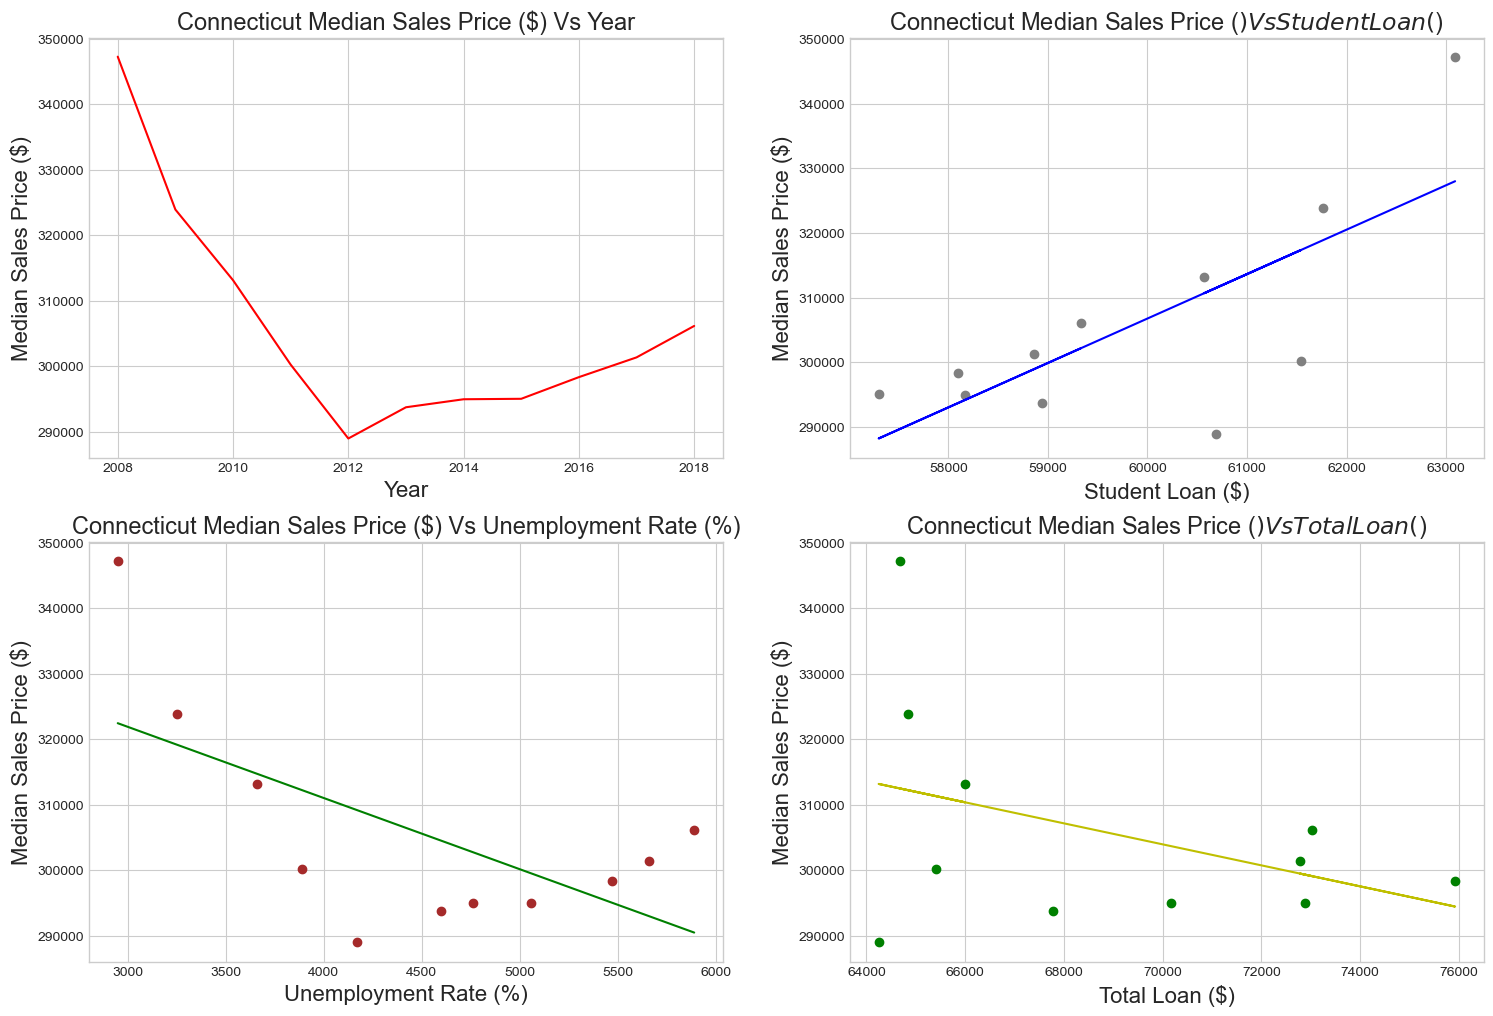

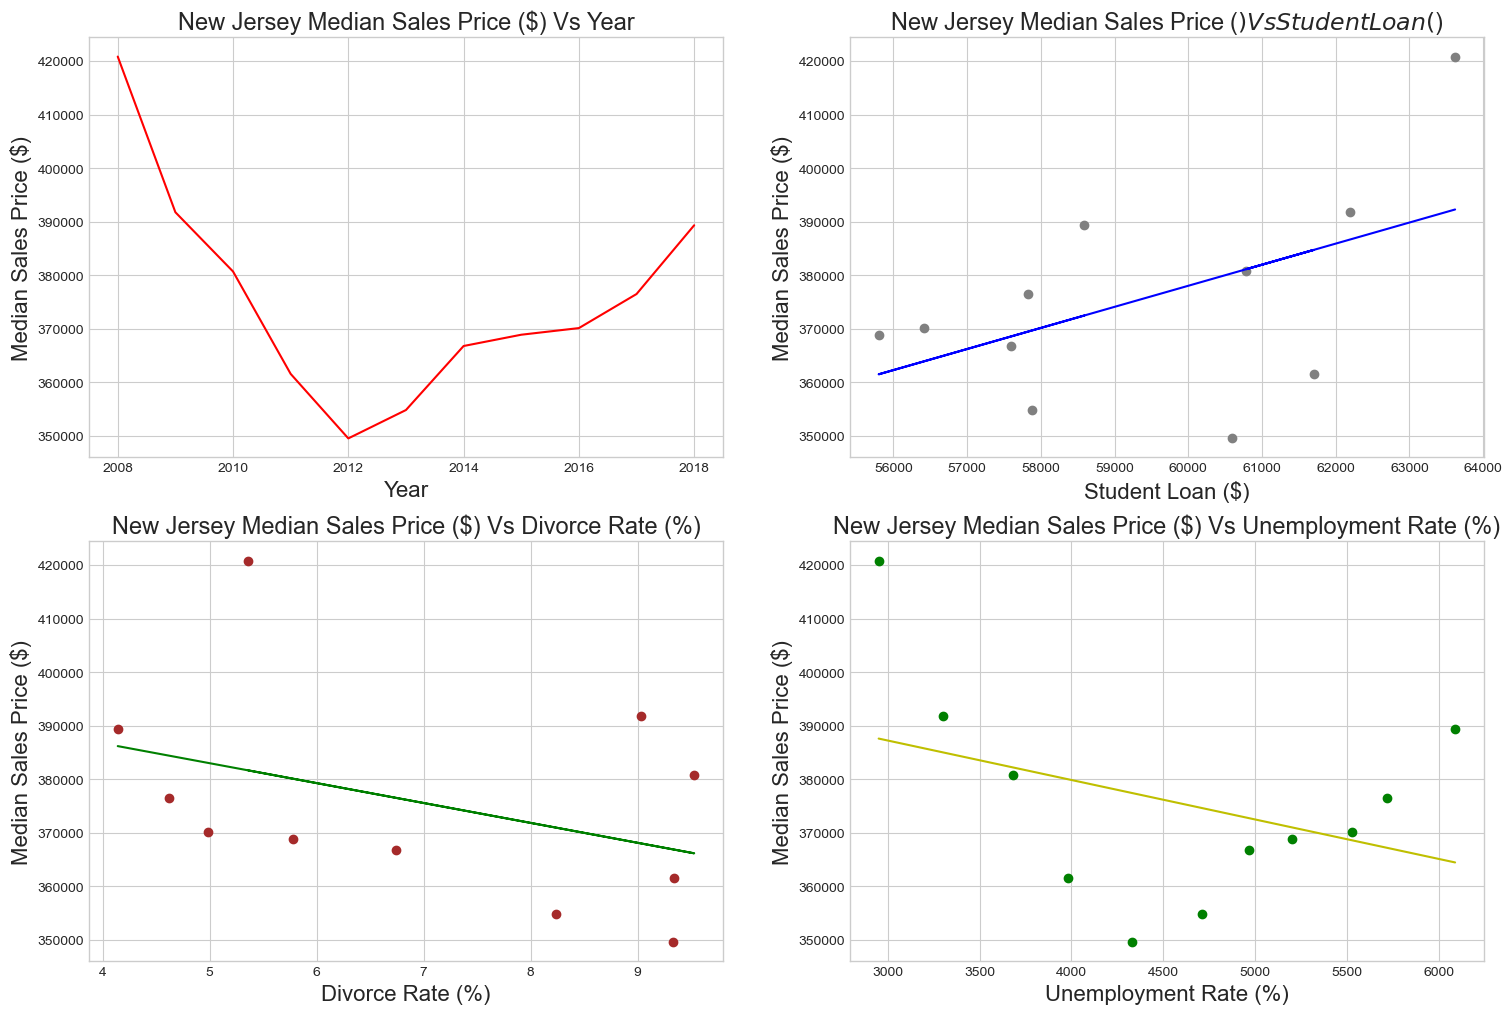

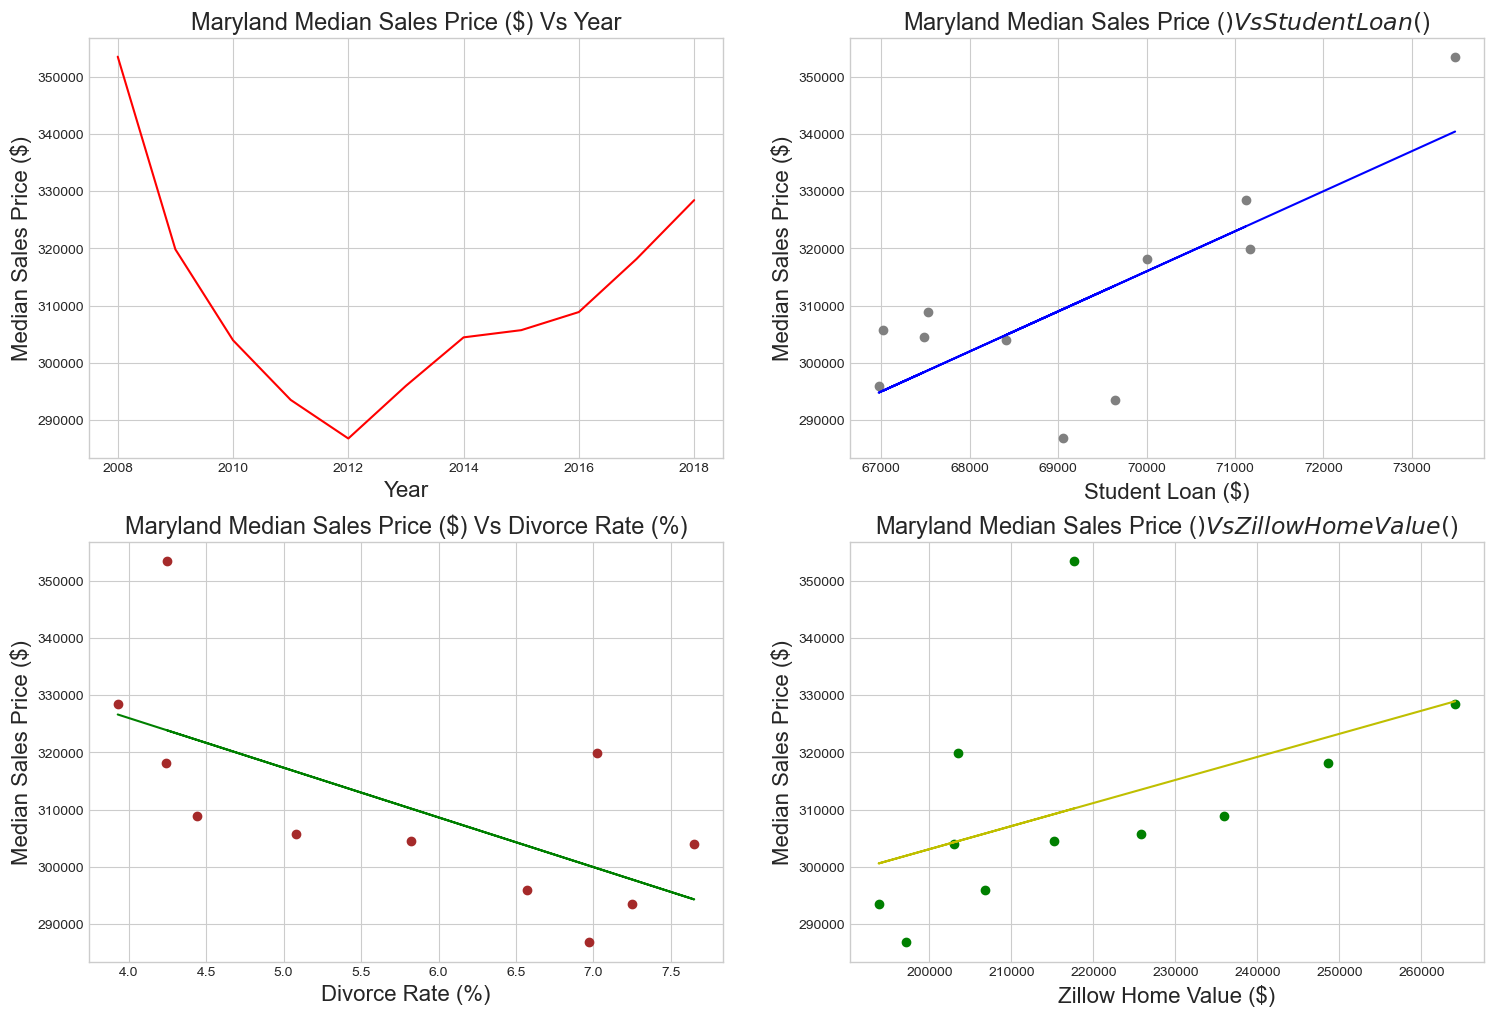

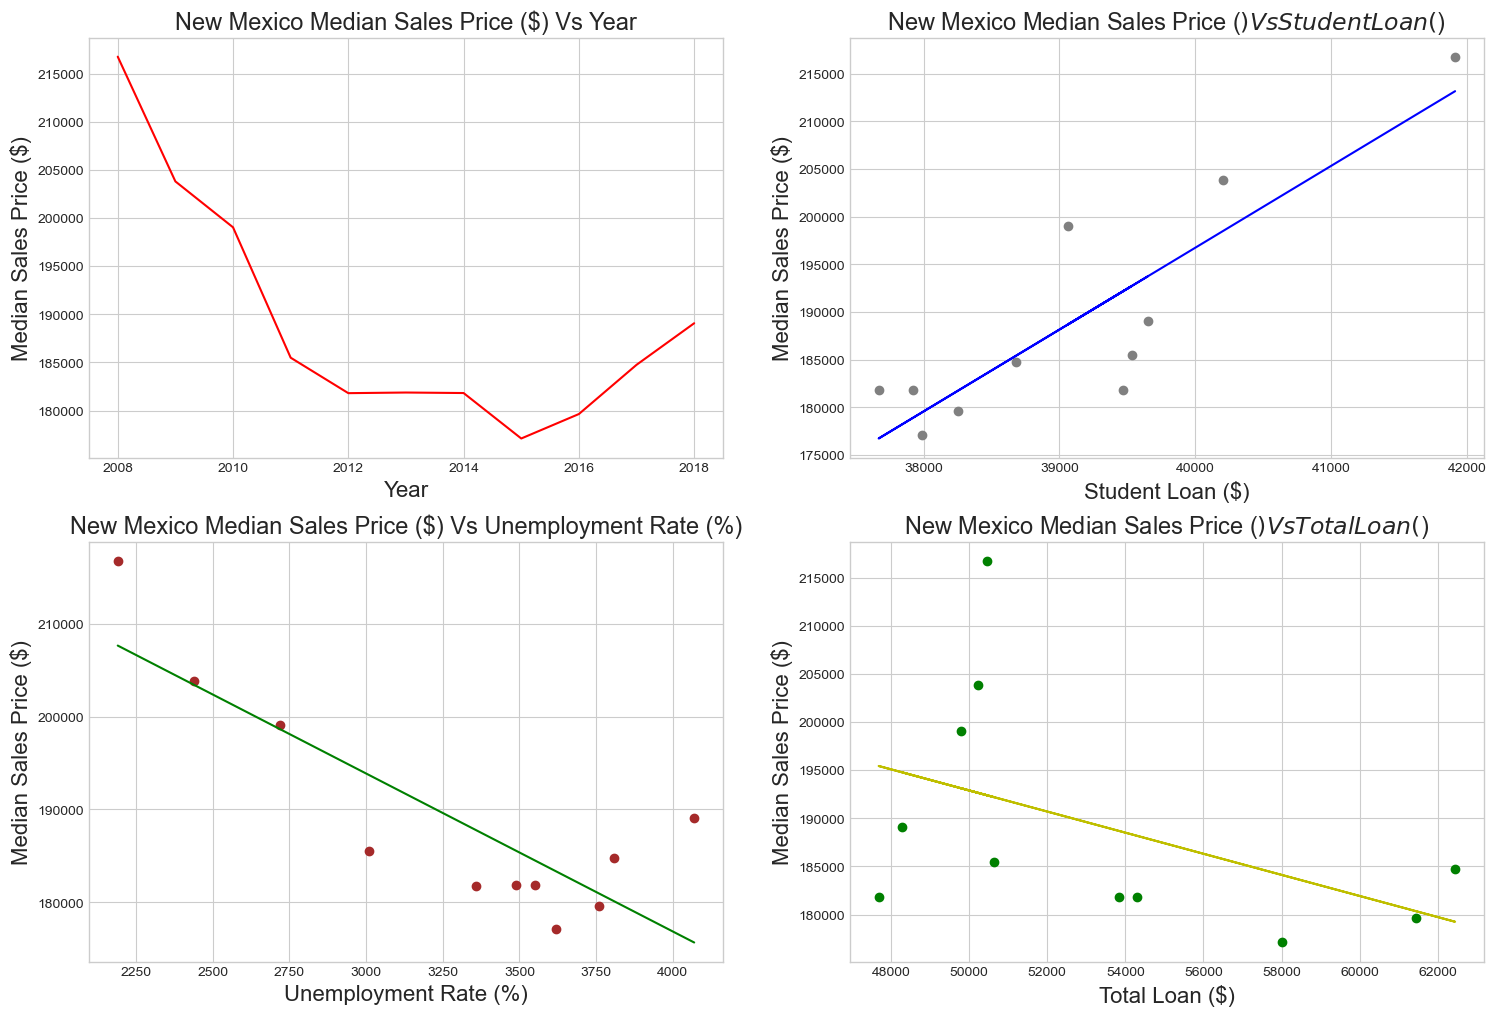

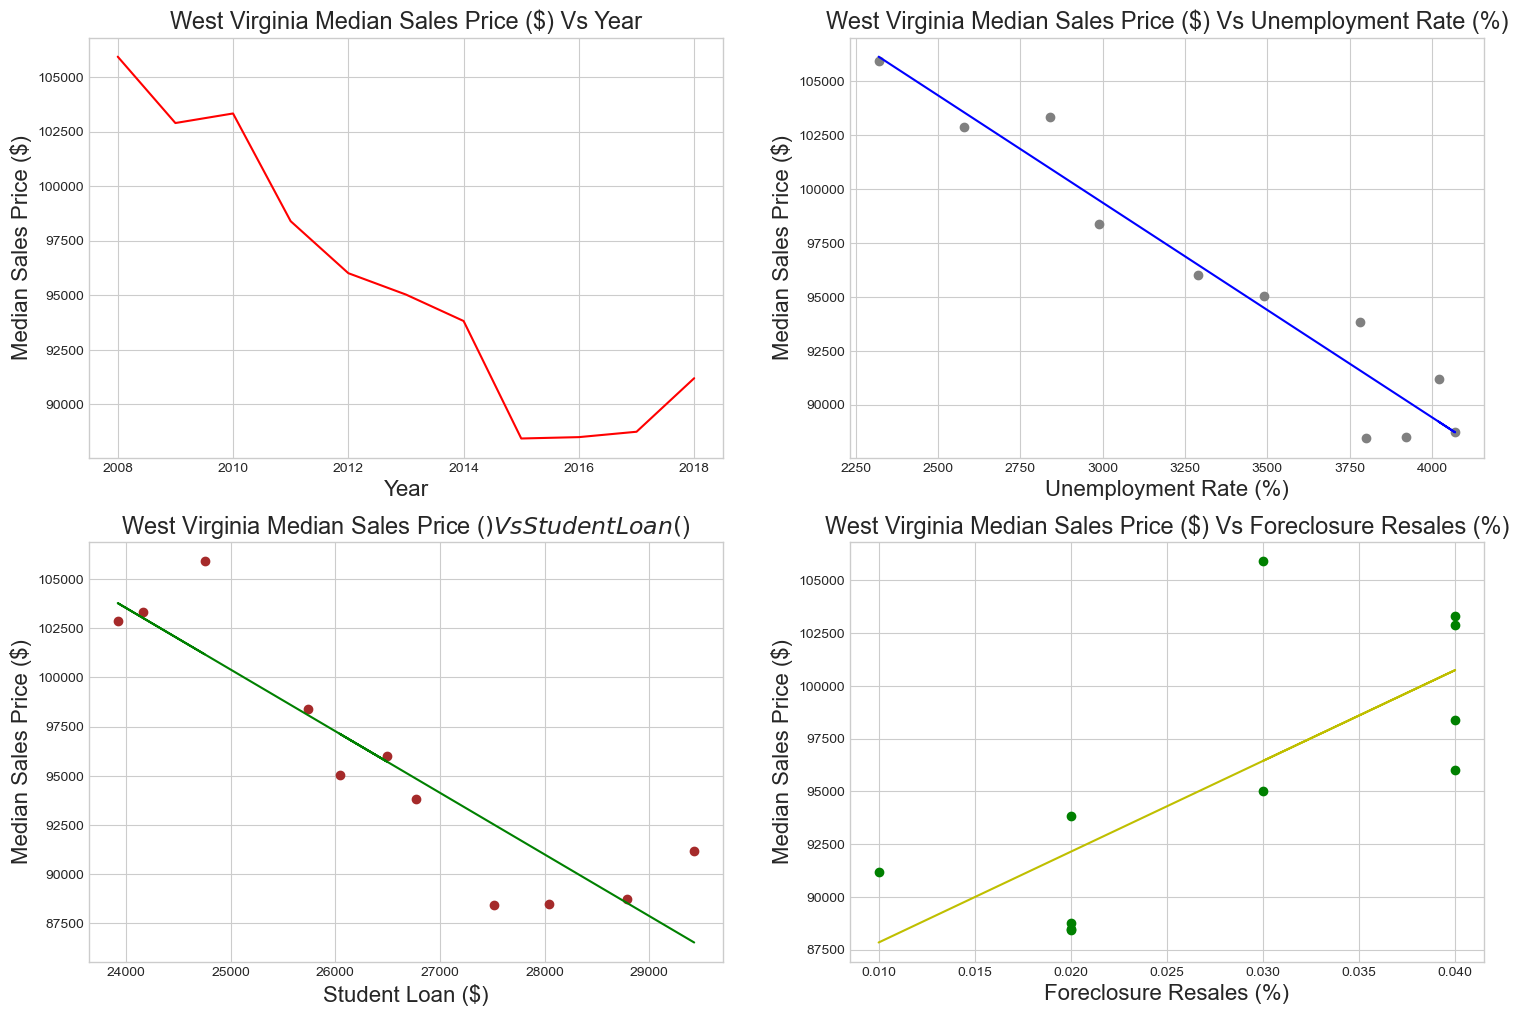

In [31]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest decrease in MSR
greatest_decrease = ["CT","NJ","MD","NM","WV"]
[showStatedata(x) for x in greatest_decrease]

In [32]:
def predictmsr(data):
    # Transpose data to make states the columns
    x = massive_data.T
    
    state = str(data).upper()
   
    ak = x[state]
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    # Get full name of the state by state code
    state_keys = list(us_state_abbreviations.keys())
    state_values = list(us_state_abbreviations.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]
    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    
    state_df.fillna(state_df.mean(), inplace=True)
    
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    corr_df = state_df[corr]    
    
    print(f'The strongest factors that correlate with {name_state} are: {corr_df.iloc[:,0].name} , {corr_df.iloc[:,1].name} and {corr_df.iloc[:,2].name}')
    time.sleep(1)
    response = input("Would you like to run a regression?  ").upper()
    time.sleep(1)
    try:
        if (response == "YES") or (response == "Y") or (response == "YEAH") or (response == "YUP"):
            ## Convert to floats and store x and y values
            X = pd.DataFrame({corr_df.index.name:corr_df.index, 
                              corr_df.iloc[:,0].name:corr_df.iloc[:,0], 
                              corr_df.iloc[:,1].name:corr_df.iloc[:,1]})
            Y = state_df["Median Sales Price ($)"]
            # with sklearn run linear regression
            regr = linear_model.LinearRegression()
            regr.fit(X, Y)
            print(f"RUNNING MULTIPLE REGRESSION ON {name_state.upper()}")
            print("--------------------------------------------------------")
            time.sleep(1)
            print('Intercept: \n', regr.intercept_)
            print('Coefficients: \n', regr.coef_)
            # Take first user input based on highest correlation
            first =float(input(f'Type {X.iloc[:,0].name}:  '))
            # Take second user input based on highest correlation
            time.sleep(0.5)
            second =float(input(f'Type {X.iloc[:,1].name}:  '))
            # Take third user input based on highest correlation
            time.sleep(0.5)
            third = float(input(f'Type {X.iloc[:,2].name}:  '))
            # Run regression based on first, second and third input
            regr = round(int(regr.predict([[first ,second, third]])),2)
            #regr = round(int(regr.predict([[first ,second]])),2)
            time.sleep(1)
            print(f'Predicted {name_state} Median Sales Price: ${regr:,}')
        if (response == "NO") or (response == "N") or (response == 'NOP') or (response == 'NAH'):
            print("Goodbye!")
    except:
        print("Enter a valid response!")
        pass
    return

## Predict California MSR for any year based on strongest Correlation factors


In [37]:
predictmsr("dc")

The strongest factors that correlate with District of Columbia are: Foreclosure Resales (%) , Zillow Home Value ($) and Student Loan ($)
Would you like to run a regression?  yes
RUNNING MULTIPLE REGRESSION ON DISTRICT OF COLUMBIA
--------------------------------------------------------
Intercept: 
 -14505164.07960873
Coefficients: 
 [ 7.37583077e+03 -1.89947041e+06  1.07667955e+00]
Type Year:  2008
Type Foreclosure Resales (%):  3
Type Zillow Home Value ($):  110000


C:\Users\vyshn\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Predicted District of Columbia Median Sales Price: $-5,274,472
